# AEBS - AEJxLPL_2F and AEJxPBL_2F products
Demonstration of `AEJxLPL_2F` and `AEJxPBL_2F` products.

Feel free to change the `SPACECRAFT` and `TIME` paramteres and re-run the notebook.

The notebook retrieves and displays data for one satellite orbit matched by the provided input time.

In [1]:
#------------------------------------------------------------------------------
# User input:

SPACECRAFT = 'A'
TIME = '2015-06-02T00:00:00Z'

SERVER_URL = None # default VirES server

#------------------------------------------------------------------------------

from viresclient import SwarmRequest
from viresclient._wps.time_util import parse_datetime

# point types
MASK_EJ_TYPE = PT_EEJ = 0x1
MASK_POINT_TYPE = PT_BOUNDARY = 0x2
MASK_BOUNDARY_TYPE = PT_POLAR = 0x4
MASK_BOUNDARY_FLAG = PT_END = 0x8
PT_WEJ = PT_PEAK = PT_EQUATORIAL = PT_START = 0x0

try:
    request = SwarmRequest(SERVER_URL)

    orbit_number = request.get_orbit_number(SPACECRAFT, parse_datetime(TIME))
    start_time, end_time =  request.get_times_for_orbits(SPACECRAFT, orbit_number, orbit_number)
    print('Spacecraft:   %s' % SPACECRAFT)
    print('Orbit number: %s' % orbit_number)
    print('Start time:  ', start_time)
    print('End time:    ', end_time)
    
    # retrieve latitude profiles
    request.set_collection('SW_OPER_AEJ%sLPL_2F' % SPACECRAFT)
    request.set_products(
        measurements=['Latitude_QD', 'Longitude_QD', 'MLT_QD', 'J_NE', 'J_QD'],
        auxiliaries=['QDOrbitDirection', 'OrbitDirection', 'OrbitNumber'],
    )
    response = request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=False,
    )
    print('Sources:\n\t%s' % '\n\t'.join(response.sources))
    profile = response.as_xarray()
    
    # retrieve peeks and boundaries
    request.set_collection('SW_OPER_AEJ%sPBL_2F' % SPACECRAFT)
    request.set_products(
        measurements=['Latitude_QD', 'Longitude_QD', 'MLT_QD', 'J_QD', 'Flags', 'PointType'],
        auxiliaries=['QDOrbitDirection', 'OrbitDirection', 'OrbitNumber'],
    )
    response = request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=False,
    )
    print('Sources:\n\t%s' % '\n\t'.join(response.sources))
    boundaries = response.as_xarray()

    # retrieve spacecraft orbit
    request.set_collection('SW_OPER_MAG%s_LR_1B' % SPACECRAFT)
    request.set_products(
        measurements=[],
        auxiliaries=['QDLat', 'QDLon', 'MLT'],
    )
    response = request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=False,
    )
    print('Sources:\n\t%s' % '\n\t'.join(response.sources))
    orbit = response.as_xarray()

except Exception as error:
    print('ERROR: ', error)
else:
    print(profile)
    print(boundaries)
    print(orbit)


Spacecraft:   A
Orbit number: 8528
Start time:   2015-06-01 23:46:18.406025
End time:     2015-06-02 01:19:59.576380


      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.106MB)


Sources:
	SW_OPER_AEJALPL_2F_20150602T000000_20150602T235959_0102
	SW_OPER_AUXAORBCNT_20131122T000000_20201003T000000_0001
	SW_OPER_MAGA_LR_1B_20150602T000000_20150602T235959_0505_MDR_MAG_LR


      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.115MB)


Sources:
	SW_OPER_AEJAPBL_2F_20150101T000000_20151231T235959_0102
	SW_OPER_AUXAORBCNT_20131122T000000_20201003T000000_0001
	SW_OPER_MAGA_LR_1B_20150602T000000_20150602T235959_0505_MDR_MAG_LR


      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.328MB)

Sources:
	SW_OPER_MAGA_LR_1B_20150601T000000_20150601T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150602T000000_20150602T235959_0505_MDR_MAG_LR
<xarray.Dataset>
Dimensions:           (NE: 2, Timestamp: 160)
Coordinates:
  * Timestamp         (Timestamp) datetime64[ns] 2015-06-02T00:00:08.801648378 ... 2015-06-02T01:08:35.908726454
  * NE                (NE) <U1 'N' 'E'
Data variables:
    Spacecraft        (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    OrbitDirection    (Timestamp) int8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    J_QD              (Timestamp) float64 14.45 14.06 12.9 ... -19.1 -17.85
    OrbitNumber       (Timestamp) int32 8528 8528 8528 8528 ... 8528 8528 8528
    J_NE              (Timestamp, NE) float64 -3.485 14.03 ... 4.477 -17.28
    QDOrbitDirection  (Timestamp) int8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    Latitude_QD       (Timestamp) float64 50.48 51.51 52.55 ... -51.48 -50.45
    Longitude         (Timestamp) float64 -165.0 -164.9 -16

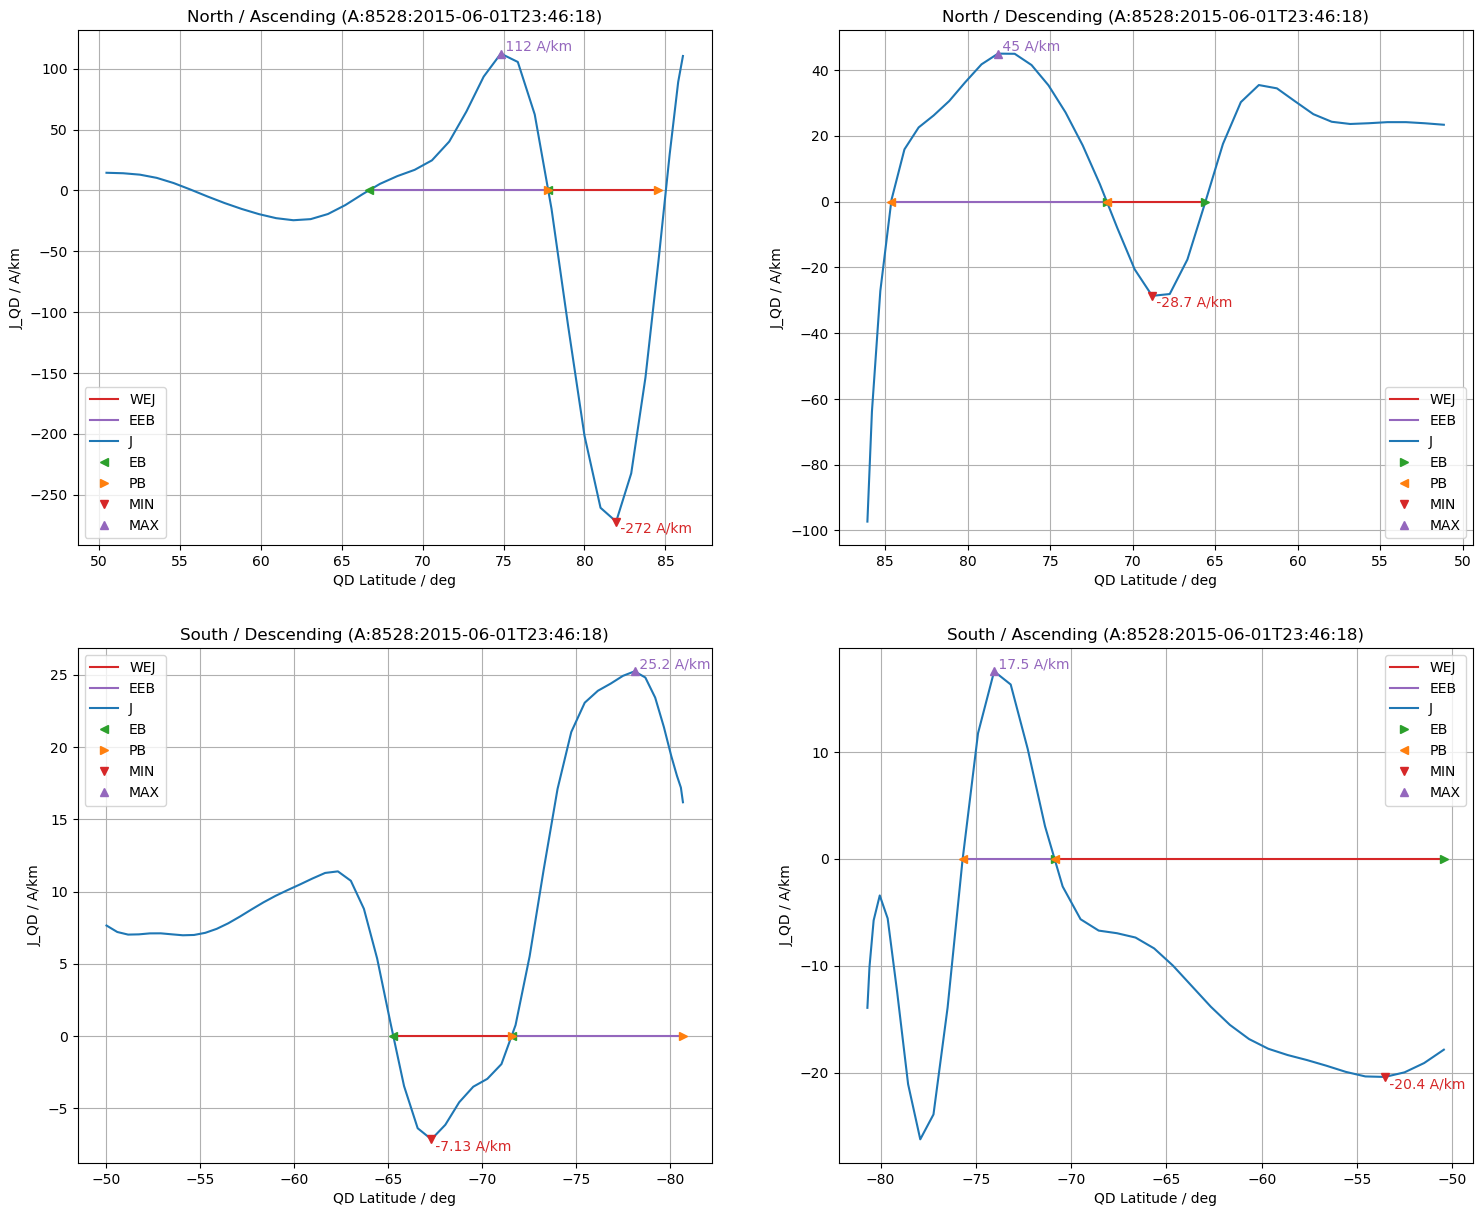

In [2]:
from numpy import isnan, logical_and, zeros, abs as aabs
from matplotlib.pyplot import figure, subplot, show
%matplotlib inline

def get_quadrant_mask(data, ascending, north):
    orbit_direction = data['QDOrbitDirection'].values
    latitude = data['Latitude_QD'].values
    return logical_and(
        (orbit_direction > 0 if ascending else orbit_direction < 0),
        (latitude > 0 if north else latitude < 0)
    )


def format_time(time):
    return time.replace(microsecond=0).isoformat()


def get_title(ascending, north):
    pass_ = 'Ascending' if ascending else 'Descending'
    hemisphere = 'North' if north else 'South'
    return '%s / %s (%s:%s:%s)' % (hemisphere, pass_, SPACECRAFT, orbit_number, format_time(start_time))


def plot(ax, ascending, north):
    p_mask = get_quadrant_mask(profile, ascending=ascending, north=north)
    b_mask = get_quadrant_mask(boundaries, ascending=ascending, north=north)
    
    b_mask_eb = b_mask & (point_type&(MASK_POINT_TYPE|MASK_BOUNDARY_TYPE) == PT_BOUNDARY|PT_EQUATORIAL)
    b_mask_pb = b_mask & (point_type&(MASK_POINT_TYPE|MASK_BOUNDARY_TYPE) == PT_BOUNDARY|PT_POLAR)
    b_mask_min = b_mask & (point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_WEJ|PT_PEAK)
    b_mask_max = b_mask & (point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_EEJ|PT_PEAK)

    b_mask_wej = b_mask & (point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_WEJ|PT_BOUNDARY)
    b_mask_eej = b_mask & (point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_EEJ|PT_BOUNDARY)

    l_wej, = ax.plot(b_qd_latitude[b_mask_wej], zeros(b_qd_latitude[b_mask_wej].shape), color='tab:red')
    l_eej, = ax.plot(b_qd_latitude[b_mask_eej], zeros(b_qd_latitude[b_mask_eej].shape), color='tab:purple')
    l_j, = ax.plot(p_qd_latitude[p_mask], p_qd_j[p_mask])
    l_eb, = ax.plot(b_qd_latitude[b_mask_eb], b_qd_j[b_mask_eb], '<' if north==ascending else '>', color='tab:green')
    l_pb, = ax.plot(b_qd_latitude[b_mask_pb], b_qd_j[b_mask_pb], '>' if north==ascending else '<', color='tab:orange')
    l_min, = ax.plot(b_qd_latitude[b_mask_min], b_qd_j[b_mask_min], 'v', color='tab:red')
    l_max, = ax.plot(b_qd_latitude[b_mask_max], b_qd_j[b_mask_max], '^', color='tab:purple')
    
    if not ascending:
        xmin, xmax = ax.get_xlim(); ax.set_xlim((xmax, xmin)) # flip x axis
    
    ax.grid()
    ax.set_title(get_title(ascending=ascending, north=north))
    ax.set_xlabel('QD Latitude / deg')
    ax.set_ylabel('J_QD / A/km')
    ax.legend(
        (l_wej, l_eej, l_j, l_eb, l_pb, l_min, l_max),
        ('WEJ', 'EEB', 'J', 'EB', 'PB', 'MIN', 'MAX')
    )
    
    for x, y in zip(b_qd_latitude[b_mask_min], b_qd_j[b_mask_min]):
        ax.text(x, y, ' %.3g A/km' % y, color='tab:red', va='top', ha='left')
    for x, y in zip(b_qd_latitude[b_mask_max], b_qd_j[b_mask_max]):
        ax.text(x, y, ' %.3g A/km' % y, color='tab:purple', va='bottom', ha='left')

        
p_qd_latitude = profile['Latitude_QD'].values
p_qd_j = profile['J_QD'].values

b_qd_latitude = boundaries['Latitude_QD'].values
b_qd_j = boundaries['J_QD'].values
b_qd_j[isnan(b_qd_j)] = 0
point_type = boundaries['PointType'].values

fig = figure(figsize=(18, 15), dpi=100)
plot(subplot(221), ascending=True, north=True)
plot(subplot(222), ascending=False, north=True)
plot(subplot(223), ascending=False, north=False)
plot(subplot(224), ascending=True, north=False)

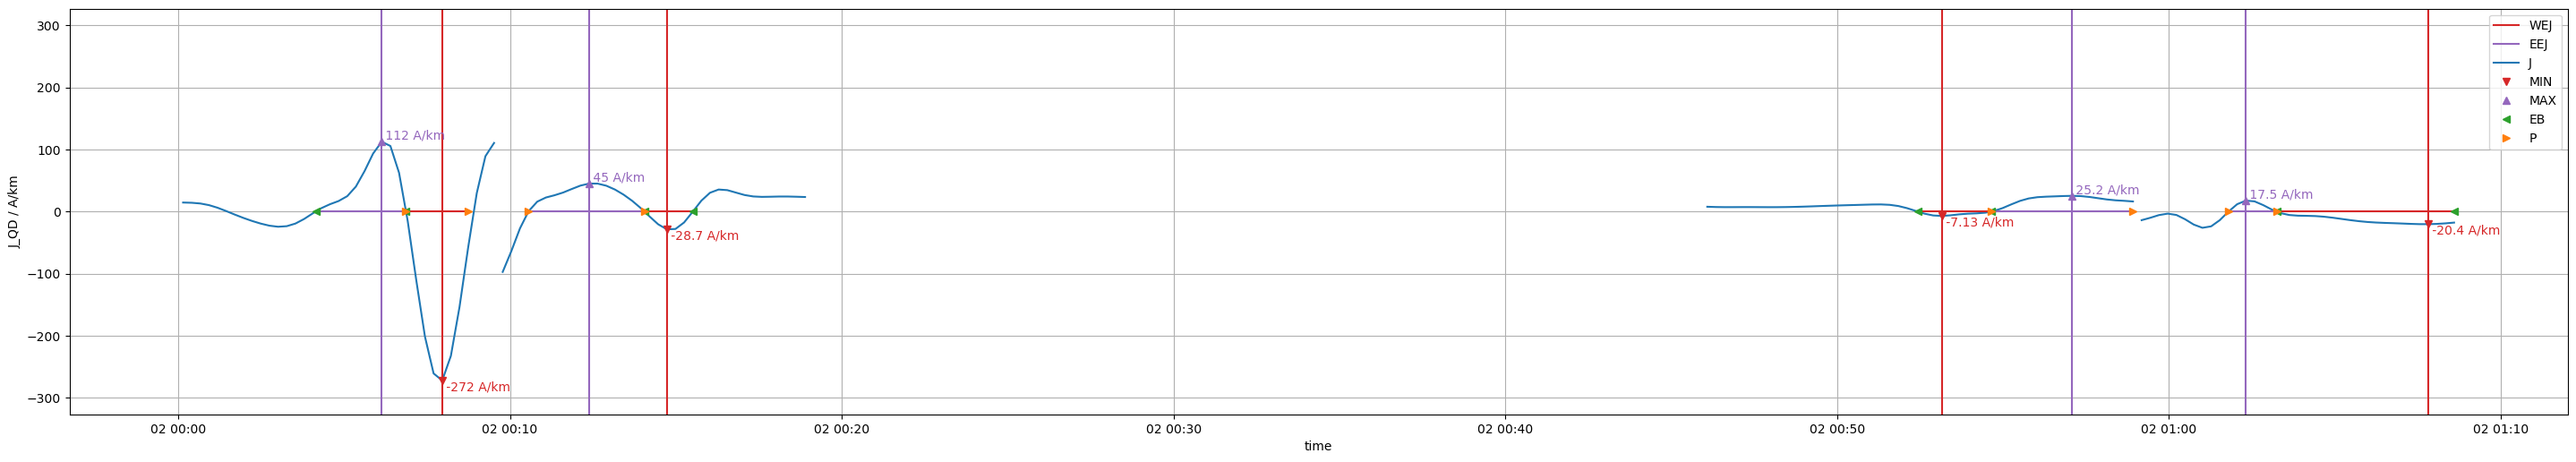

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

p_time = profile['Timestamp'].values
p_qd_j = profile['J_QD'].values

b_time = boundaries['Timestamp'].values
b_qd_j = boundaries['J_QD'].values
b_qd_j[isnan(b_qd_j)] = 0
point_type = boundaries['PointType'].values

def plot(ax):
    
    def _plot(ascending, north):
        p_mask = get_quadrant_mask(profile, ascending=ascending, north=north)
        l_j, = ax.plot(p_time[p_mask], p_qd_j[p_mask], '-', markersize=4, label='J', color='tab:blue')
        return l_j
    
    l_j = _plot(ascending=True, north=True)
    l_j = _plot(ascending=False, north=True)
    l_j = _plot(ascending=False, north=False)
    l_j = _plot(ascending=True, north=False)
    
    b_mask_eb = point_type&(MASK_POINT_TYPE|MASK_BOUNDARY_TYPE) == PT_BOUNDARY|PT_EQUATORIAL
    b_mask_pb = point_type&(MASK_POINT_TYPE|MASK_BOUNDARY_TYPE) == PT_BOUNDARY|PT_POLAR
    b_mask_min = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_WEJ|PT_PEAK
    b_mask_max = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_EEJ|PT_PEAK

    b_mask_wej_start = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE|MASK_BOUNDARY_FLAG) == PT_WEJ|PT_BOUNDARY|PT_START
    b_mask_wej_end = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE|MASK_BOUNDARY_FLAG) == PT_WEJ|PT_BOUNDARY|PT_END
    b_mask_eej_start = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE|MASK_BOUNDARY_FLAG) == PT_EEJ|PT_BOUNDARY|PT_START
    b_mask_eej_end = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE|MASK_BOUNDARY_FLAG) == PT_EEJ|PT_BOUNDARY|PT_END

    ymax = 1.2 * aabs(p_qd_j).max()
    for x in b_time[b_mask_min]:
        ax.plot([x, x], [-ymax, ymax], '-', color='tab:red')
    for x in b_time[b_mask_max]:
        ax.plot([x, x], [-ymax, ymax], '-', color='tab:purple')
    
    for x0, x1 in zip(b_time[b_mask_wej_start], b_time[b_mask_wej_end]):
        l_wej, = ax.plot([x0, x1], [0, 0], color='tab:red')

    for x0, x1 in zip(b_time[b_mask_eej_start], b_time[b_mask_eej_end]):
        l_eej, = ax.plot([x0, x1], [0, 0], color='tab:purple')
    
    l_eb, = ax.plot(b_time[b_mask_eb], b_qd_j[b_mask_eb], '<', color='tab:green')
    l_pb, = ax.plot(b_time[b_mask_pb], b_qd_j[b_mask_pb], '>', color='tab:orange')
    l_min, = ax.plot(b_time[b_mask_min], b_qd_j[b_mask_min], 'v', color='tab:red')
    l_max, = ax.plot(b_time[b_mask_max], b_qd_j[b_mask_max], '^', color='tab:purple')
  
    ax.grid()
    
    ax.set_xlabel('time')
    ax.set_ylabel('J_QD / A/km')

    for x, y in zip(b_time[b_mask_min], b_qd_j[b_mask_min]):
        ax.text(x, y, ' %.3g A/km' % y, color='tab:red', va='top', ha='left')
    for x, y in zip(b_time[b_mask_max], b_qd_j[b_mask_max]):
        ax.text(x, y, ' %.3g A/km' % y, color='tab:purple', va='bottom', ha='left')
    
    #ymax = aabs(ax.get_ylim()).max();
    ax.set_ylim((-ymax, ymax)) # center y axis around 0
    ax.legend((l_wej, l_eej, l_j, l_min, l_max, l_eb, l_pb), ('WEJ', 'EEJ', 'J', 'MIN', 'MAX', 'EB', 'P' ))


fig = figure(figsize=(36, 6), dpi=100)
plot(subplot(1, 1, 1))

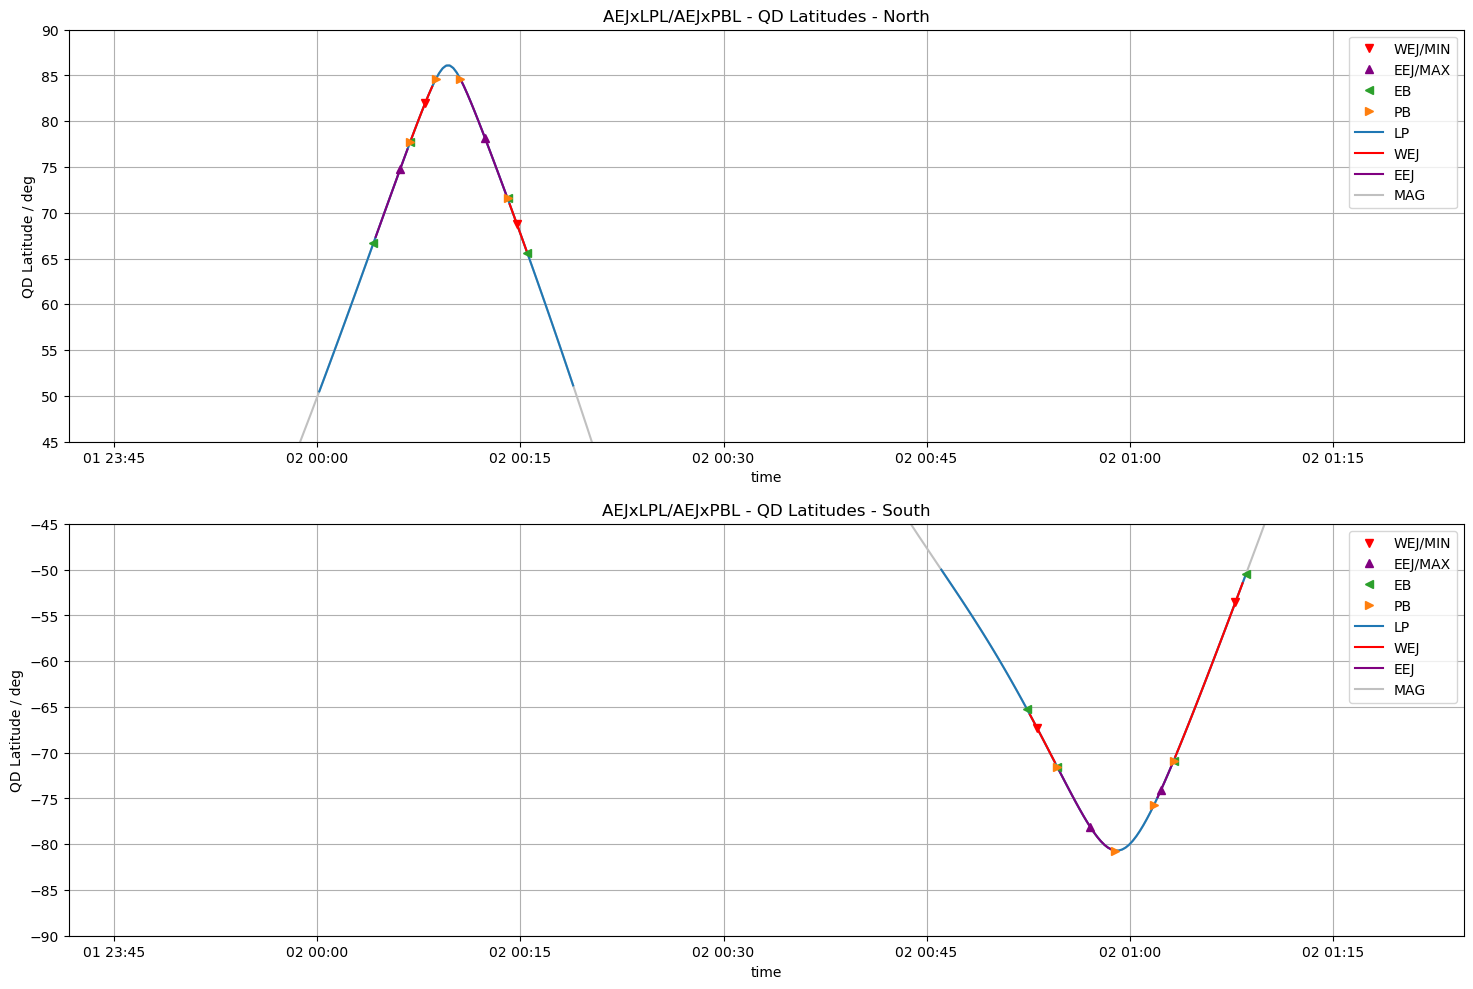

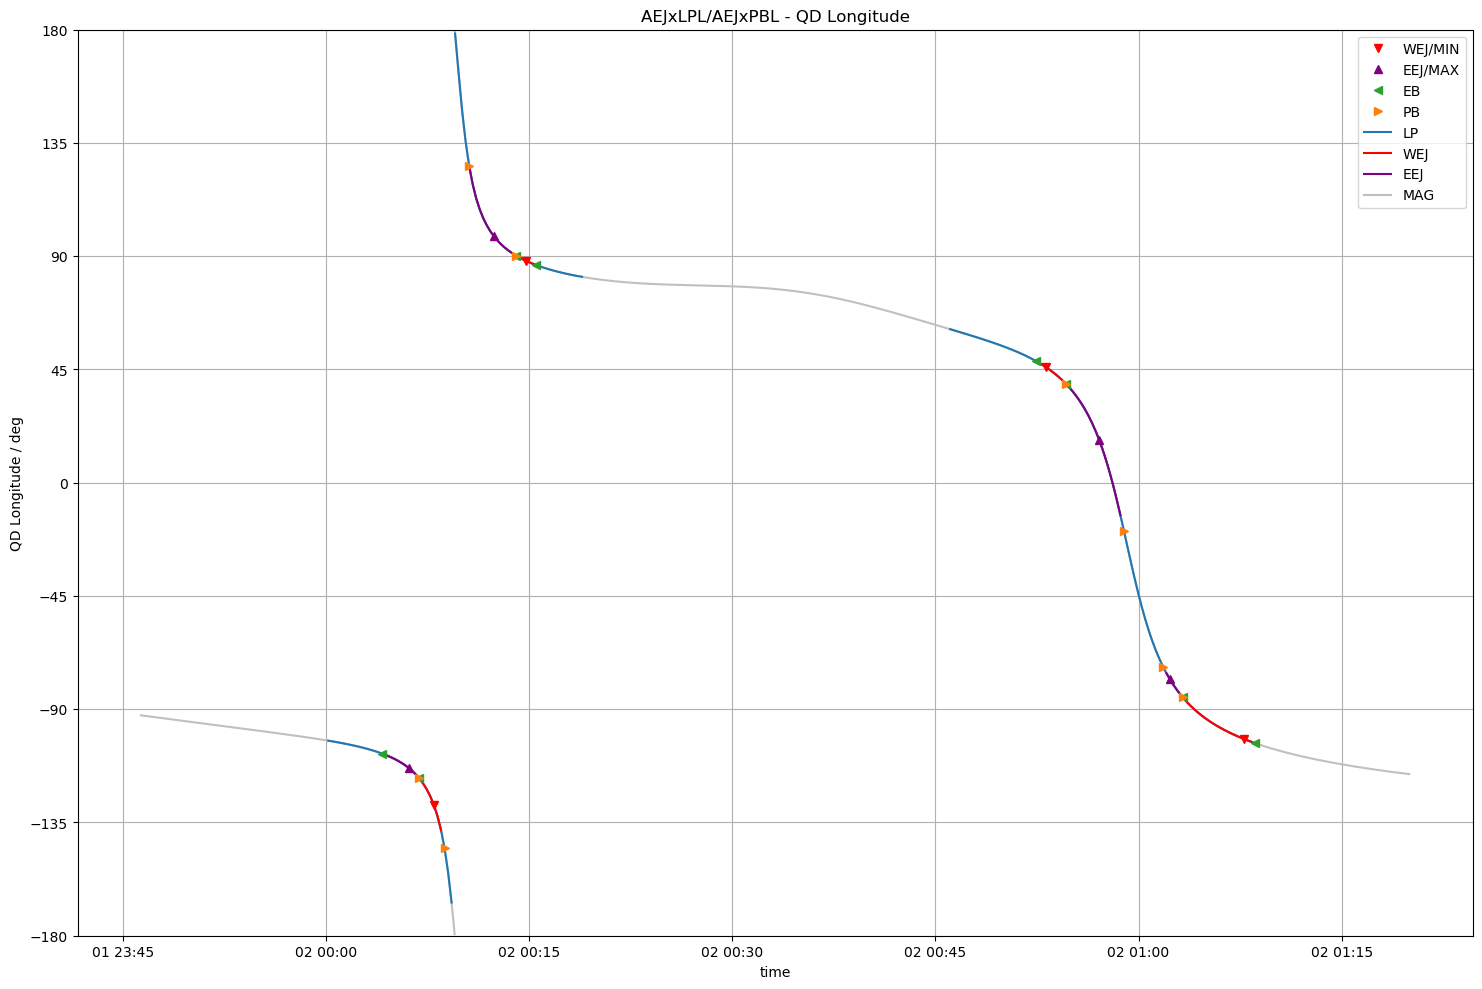

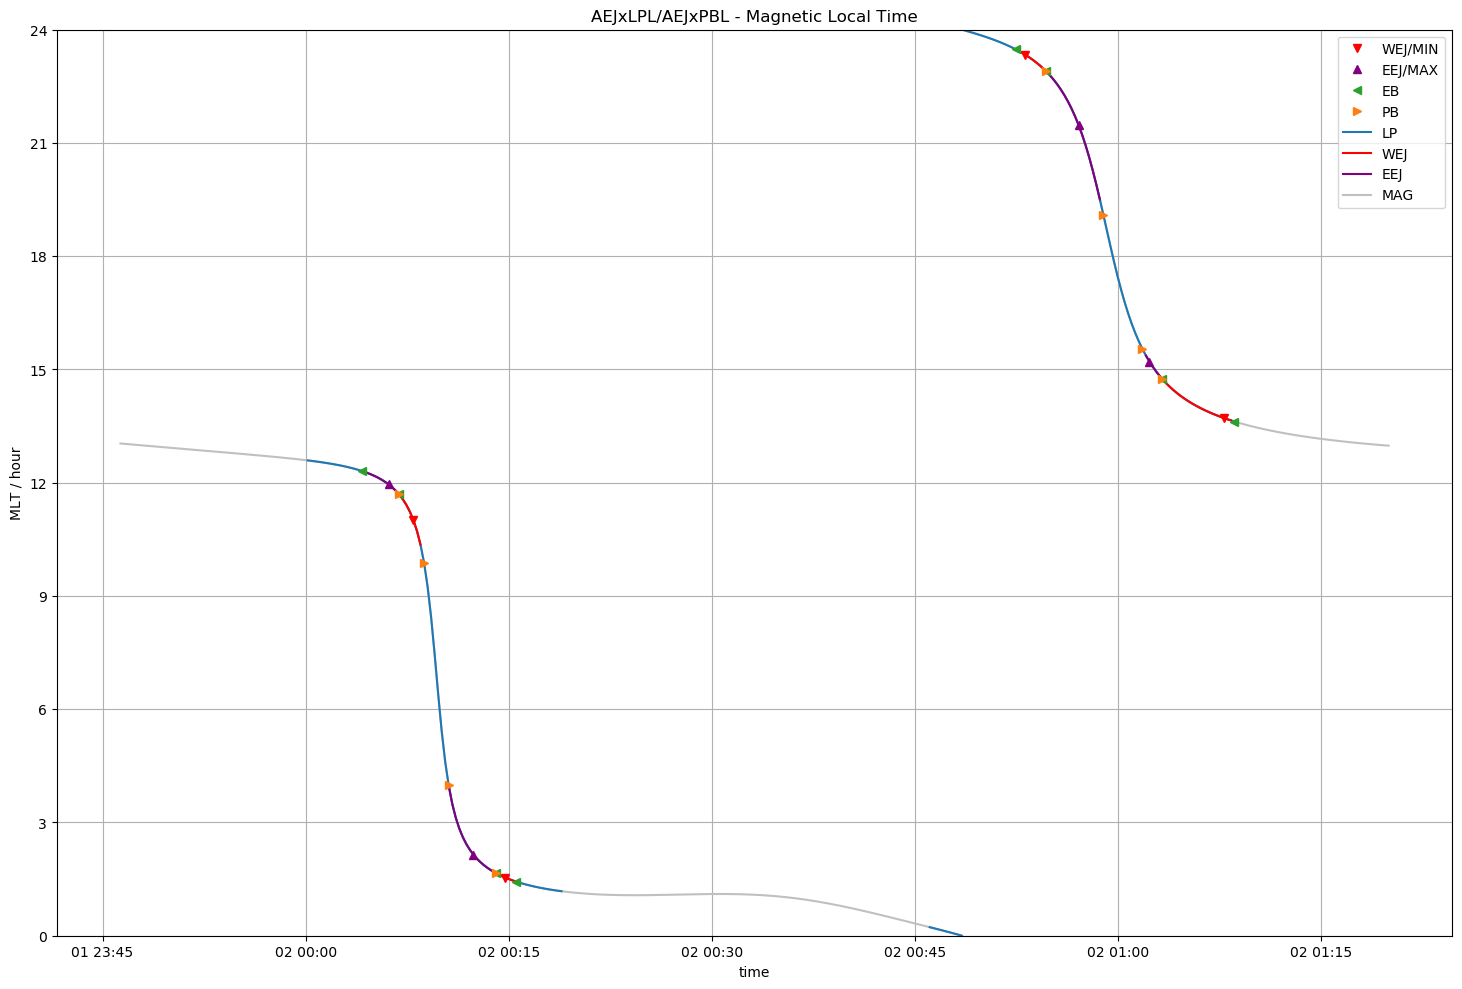

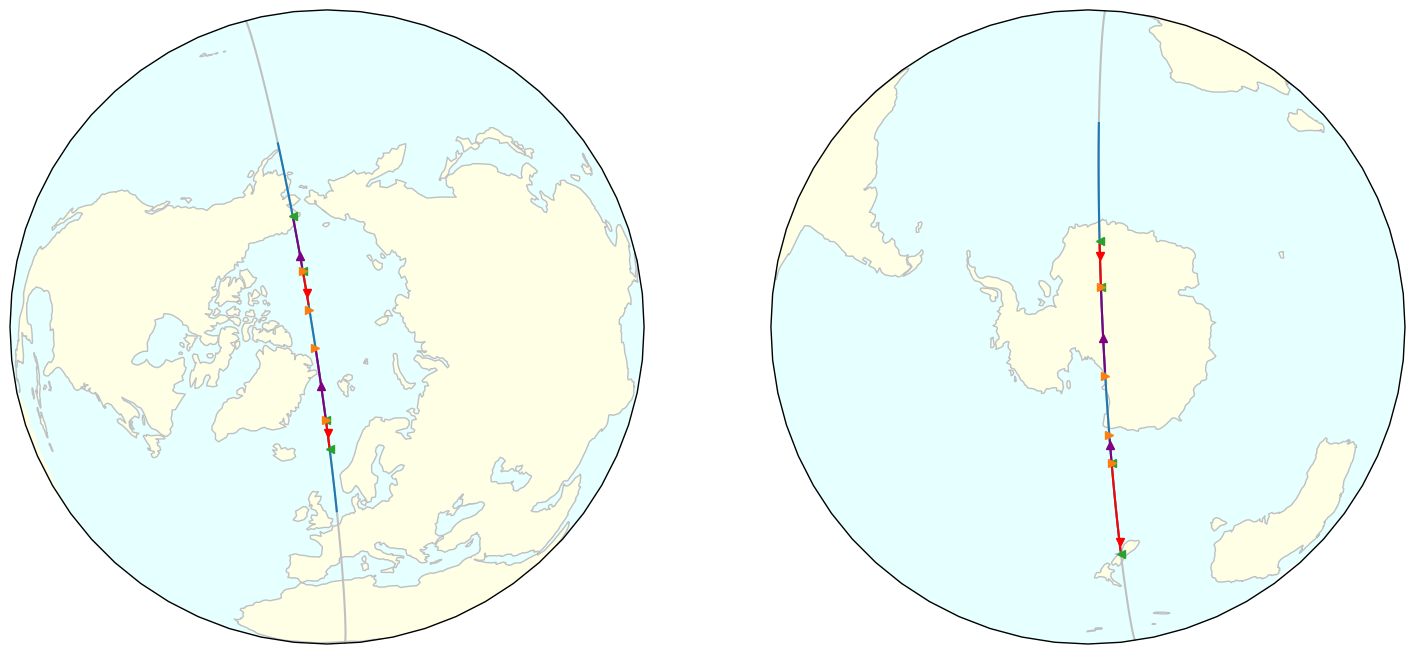

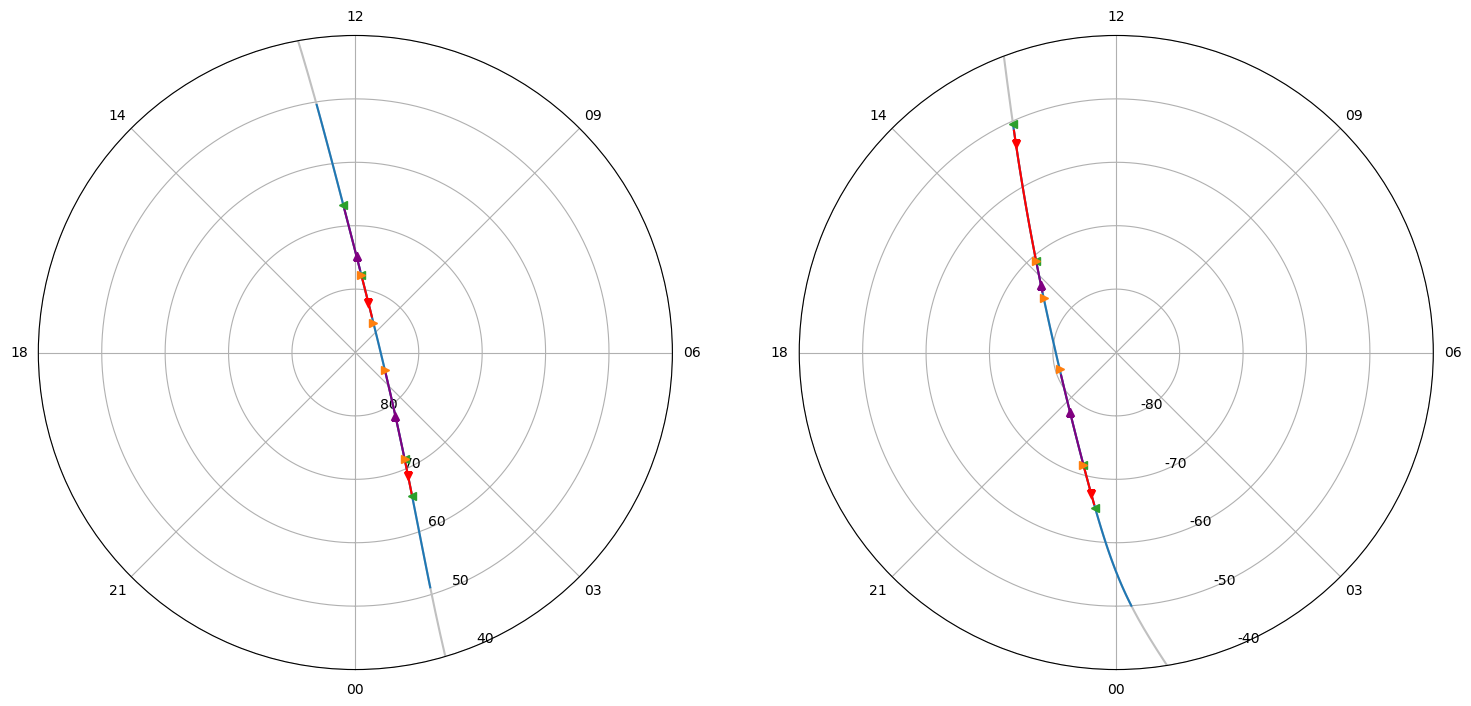

In [4]:
from numpy import isnan, logical_and, abs as aabs, cumsum, stack, pi, concatenate, timedelta64
from matplotlib.pyplot import figure, subplot, show
from scipy.interpolate import interp1d
from cartopy.feature import LAND, OCEAN, COASTLINE
from cartopy.crs import Mollweide, Orthographic, PlateCarree
%matplotlib inline

time_threshold = timedelta64(20, 's')

# latitude profile
p_time = profile['Timestamp'].values
p_lat = profile['Latitude'].values
p_lon = profile['Longitude'].values
p_lat_qd = profile['Latitude_QD'].values
p_lon_qd = profile['Longitude_QD'].values
p_mlt = profile['MLT_QD'].values

# boubdaries
b_time = boundaries['Timestamp'].values
b_lat = boundaries['Latitude'].values
b_lon = boundaries['Longitude'].values
b_lat_qd = boundaries['Latitude_QD'].values
b_lon_qd = boundaries['Longitude_QD'].values
b_mlt = boundaries['MLT_QD'].values
point_type = boundaries['PointType'].values

b_mask_eb = point_type&(MASK_POINT_TYPE|MASK_BOUNDARY_TYPE) == PT_BOUNDARY|PT_EQUATORIAL
b_mask_pb = point_type&(MASK_POINT_TYPE|MASK_BOUNDARY_TYPE) == PT_BOUNDARY|PT_POLAR
b_mask_peak_eej = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_EEJ|PT_PEAK
b_mask_peak_wej = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_WEJ|PT_PEAK
b_mask_eej = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_EEJ|PT_BOUNDARY
b_mask_wej = point_type&(MASK_EJ_TYPE|MASK_POINT_TYPE) == PT_WEJ|PT_BOUNDARY
b_eej_pair_start = point_type[b_mask_eej]&MASK_BOUNDARY_FLAG == PT_START
b_wej_pair_start = point_type[b_mask_wej]&MASK_BOUNDARY_FLAG == PT_START

# orbit from MAGx_LR products
o_time = orbit['Timestamp'].values
o_lat = orbit['Latitude'].values
o_lon = orbit['Longitude'].values
o_lat_qd = orbit['QDLat'].values
o_lon_qd = orbit['QDLon'].values
o_mlt = orbit['MLT'].values

# EJ mask -> True if point is inside WEJ or EEJ
o_mask_eej = interp1d(
    b_time[b_mask_eej].astype('int64'), b_eej_pair_start, kind='zero', bounds_error=False, fill_value=0.0
)(o_time.astype('int64')).astype('bool')
o_mask_wej = interp1d(
    b_time[b_mask_wej].astype('int64'), b_wej_pair_start, kind='zero', bounds_error=False, fill_value=0.0
)(o_time.astype('int64')).astype('bool')

p_mask_eej = interp1d(
    b_time[b_mask_eej].astype('int64'), b_eej_pair_start, kind='zero', bounds_error=False, fill_value=0.0
)(p_time.astype('int64')).astype('bool')
p_mask_wej = interp1d(
    b_time[b_mask_wej].astype('int64'), b_wej_pair_start, kind='zero', bounds_error=False, fill_value=0.0
)(p_time.astype('int64')).astype('bool')


def split_array(data, threshold, start=None, end=None):
    if start is None:
        start = 0
    if end is None:
        end = len(data)
    split = concatenate((
        [start],
        (abs(data[start+1:end] - data[start:end-1]) > threshold).nonzero()[0] + 1 + start,
        [end]
    ))
    return zip(split[:-1], split[1:])

# -----------------------------------------------------------------------------

def plot_qdlat_vs_time(ax, ylim, label): 
    is_north = min(ylim) > 0
    l_orb, = ax.plot(o_time, o_lat_qd, '-', color='silver')      
    for start, end in split_array(p_time, time_threshold):
        l_lp, = ax.plot(p_time[start:end], p_lat_qd[start:end], '-', color='tab:blue')
    for start, end in split_array(p_time[p_mask_eej], time_threshold):
        l_lp_eej, = ax.plot(p_time[p_mask_eej][start:end], p_lat_qd[p_mask_eej][start:end], '-', color='purple')
    for start, end in split_array(p_time[p_mask_wej], time_threshold):
        l_lp_wej, = ax.plot(p_time[p_mask_wej][start:end], p_lat_qd[p_mask_wej][start:end], '-', color='red')
    l_peak_eej, = ax.plot(b_time[b_mask_peak_eej], b_lat_qd[b_mask_peak_eej], '^', color='purple')
    l_peak_wej, = ax.plot(b_time[b_mask_peak_wej], b_lat_qd[b_mask_peak_wej], 'v', color='red')
    l_eb, = ax.plot(b_time[b_mask_eb], b_lat_qd[b_mask_eb], '<', color='tab:green')
    l_pb, = ax.plot(b_time[b_mask_pb], b_lat_qd[b_mask_pb], '>', color='tab:orange')
    
    ax.set_ylim(ylim)
    ax.grid()
    ax.set_title('AEJxLPL/AEJxPBL - QD Latitudes - %s' % label)
    ax.set_ylabel('QD Latitude / deg')
    ax.set_xlabel('time')
    ax.legend(
        (l_peak_wej, l_peak_eej, l_eb, l_pb, l_lp, l_lp_wej, l_lp_eej, l_orb),
        ('WEJ/MIN', 'EEJ/MAX', 'EB', 'PB', 'LP', 'WEJ', 'EEJ', 'MAG')
    )

fig = figure(figsize=(18, 12), dpi=100)
plot_qdlat_vs_time(subplot(211), (45, 90), 'North')
plot_qdlat_vs_time(subplot(212), (-90, -45), 'South')

# -----------------------------------------------------------------------------

def plot_qdlon_vs_time(ax):
    ylim = (-180, 180)
    
    for start, end in split_array(o_lon_qd, 180.0):
        l_orb, = ax.plot(o_time[start:end], o_lon_qd[start:end], '-', color='silver')
    for start0, end0 in split_array(p_time, time_threshold):
        for start, end in split_array(p_lon_qd, 180.0, start0, end0):
            l_lp, = ax.plot(p_time[start:end], p_lon_qd[start:end], '-', color='tab:blue')    
    for start0, end0 in split_array(p_time[p_mask_eej], time_threshold):
        for start, end in split_array(p_lon_qd[p_mask_eej], 180.0, start0, end0):
            l_lp_eej, = ax.plot(p_time[p_mask_eej][start:end], p_lon_qd[p_mask_eej][start:end], '-', color='purple')
    for start0, end0 in split_array(p_time[p_mask_wej], time_threshold):
        for start, end in split_array(p_lon_qd[p_mask_wej], 180.0, start0, end0):
            l_lp_wej, = ax.plot(p_time[p_mask_wej][start:end], p_lon_qd[p_mask_wej][start:end], '-', color='red')
    
    l_peak_eej, = ax.plot(b_time[b_mask_peak_eej], b_lon_qd[b_mask_peak_eej], '^', color='purple')
    l_peak_wej, = ax.plot(b_time[b_mask_peak_wej], b_lon_qd[b_mask_peak_wej], 'v', color='red')
    l_eb, = ax.plot(b_time[b_mask_eb], b_lon_qd[b_mask_eb], '<', color='tab:green')
    l_pb, = ax.plot(b_time[b_mask_pb], b_lon_qd[b_mask_pb], '>', color='tab:orange')
    
    ax.set_ylim(ylim)
    ax.set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    ax.grid()
    ax.set_title('AEJxLPL/AEJxPBL - QD Longitude')
    ax.set_ylabel('QD Longitude / deg')
    ax.set_xlabel('time')
    ax.legend(
        (l_peak_wej, l_peak_eej, l_eb, l_pb, l_lp, l_lp_wej, l_lp_eej, l_orb),
        ('WEJ/MIN', 'EEJ/MAX', 'EB', 'PB', 'LP', 'WEJ', 'EEJ', 'MAG')
    )

fig = figure(figsize=(18, 12), dpi=100)
plot_qdlon_vs_time(subplot(111))

# -----------------------------------------------------------------------------

def plot_mlt_vs_time(ax):
    ylim = (0, 24)
    
    for start, end in split_array(o_mlt, 12.0):
        l_orb, = ax.plot(o_time[start:end], o_mlt[start:end], '-', color='silver')
    for start0, end0 in split_array(p_time, time_threshold):
        for start, end in split_array(p_mlt, 12.0, start0, end0):
            l_lp, = ax.plot(p_time[start:end], p_mlt[start:end], '-', color='tab:blue')    
    for start0, end0 in split_array(p_time[p_mask_eej], time_threshold):
        for start, end in split_array(p_mlt[p_mask_eej], 12.0, start0, end0):
            l_lp_eej, = ax.plot(p_time[p_mask_eej][start:end], p_mlt[p_mask_eej][start:end], '-', color='purple')
    for start0, end0 in split_array(p_time[p_mask_wej], time_threshold):
        for start, end in split_array(p_mlt[p_mask_wej], 12.0, start0, end0):
            l_lp_wej, = ax.plot(p_time[p_mask_wej][start:end], p_mlt[p_mask_wej][start:end], '-', color='red')
    
    l_peak_eej, = ax.plot(b_time[b_mask_peak_eej], b_mlt[b_mask_peak_eej], '^', color='purple')
    l_peak_wej, = ax.plot(b_time[b_mask_peak_wej], b_mlt[b_mask_peak_wej], 'v', color='red')
    l_eb, = ax.plot(b_time[b_mask_eb], b_mlt[b_mask_eb], '<', color='tab:green')
    l_pb, = ax.plot(b_time[b_mask_pb], b_mlt[b_mask_pb], '>', color='tab:orange')
    
    ax.set_ylim(ylim)
    ax.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    ax.grid()
    ax.set_title('AEJxLPL/AEJxPBL - Magnetic Local Time')
    ax.set_ylabel('MLT / hour')
    ax.set_xlabel('time')
    ax.legend(
        (l_peak_wej, l_peak_eej, l_eb, l_pb, l_lp, l_lp_wej, l_lp_eej, l_orb),
        ('WEJ/MIN', 'EEJ/MAX', 'EB', 'PB', 'LP', 'WEJ', 'EEJ', 'MAG')
    )

fig = figure(figsize=(18, 12), dpi=100)
plot_mlt_vs_time(subplot(111))

# -----------------------------------------------------------------------------

def plot_maps(ax, north):
    h = 1 if north else -1
    gl = ax.gridlines(crs=PlateCarree(), draw_labels=False, linewidth=0, color='silver', alpha=0.5, linestyle='--')
    ax.set_xlim([-6378073.21863, 6378073.21863])
    ax.set_ylim([-6378073.21863, 6378073.21863])
    ax.add_feature(LAND, facecolor=(1.0, 1.0, 0.9))
    ax.add_feature(OCEAN, facecolor=(0.9, 1.0, 1.0))
    ax.add_feature(COASTLINE, edgecolor='silver')

    ax.plot(o_lon[o_lat*h > 0], o_lat[o_lat*h > 0], '-', color='silver', transform=PlateCarree())
    for start, end in split_array(p_time, time_threshold):
        ax.plot(p_lon[start:end], p_lat[start:end], '-', color='tab:blue', transform=PlateCarree())
    for start, end in split_array(p_time[p_mask_eej], time_threshold):
        ax.plot(p_lon[p_mask_eej][start:end], p_lat[p_mask_eej][start:end], '-', color='purple', transform=PlateCarree())
    for start, end in split_array(p_time[p_mask_wej], time_threshold):
        ax.plot(p_lon[p_mask_wej][start:end], p_lat[p_mask_wej][start:end], '-', color='red', transform=PlateCarree())
    ax.plot(b_lon[b_mask_peak_eej], b_lat[b_mask_peak_eej], '^', color='purple', transform=PlateCarree())
    ax.plot(b_lon[b_mask_peak_wej], b_lat[b_mask_peak_wej], 'v', color='red', transform=PlateCarree())
    ax.plot(b_lon[b_mask_eb], b_lat[b_mask_eb], '<', color='tab:green', transform=PlateCarree())
    ax.plot(b_lon[b_mask_pb], b_lat[b_mask_pb], '>', color='tab:orange', transform=PlateCarree())

fig = figure(figsize=(18, 9), dpi=100)
plot_maps(subplot(1, 2, 1, projection=Orthographic(0, 90)), north=True)
plot_maps(subplot(1, 2, 2, projection=Orthographic(0, -90)), north=False)

# -----------------------------------------------------------------------------

def plot_mlt(ax, north=True):
    ax.set_theta_zero_location('S')
    h = 1 if north else -1
    
    def _plot(x, y, *args, **kwargs):
        return ax.plot(x*(pi/12), 90 - y*h, *args, **kwargs)
    
    o_mask = o_lat_qd*h > 0
    for start, end in split_array(o_time[o_mask], time_threshold):
        _plot(o_mlt[o_mask][start:end], o_lat_qd[o_mask][start:end], '-', color='silver', markersize=0.15)
    for start, end in split_array(p_time, time_threshold):
        _plot(p_mlt[start:end], p_lat_qd[start:end], '-', color='tab:blue')
    for start, end in split_array(p_time[p_mask_eej], time_threshold):
        _plot(p_mlt[p_mask_eej][start:end], p_lat_qd[p_mask_eej][start:end], '-', color='purple')
    for start, end in split_array(p_time[p_mask_wej], time_threshold):
        _plot(p_mlt[p_mask_wej][start:end], p_lat_qd[p_mask_wej][start:end], '-', color='red')
    _plot(b_mlt[b_mask_peak_eej], b_lat_qd[b_mask_peak_eej], '^', color='purple')
    _plot(b_mlt[b_mask_peak_wej], b_lat_qd[b_mask_peak_wej], 'v', color='red')
    _plot(b_mlt[b_mask_eb], b_lat_qd[b_mask_eb], '<', color='tab:green')
    _plot(b_mlt[b_mask_pb], b_lat_qd[b_mask_pb], '>', color='tab:orange')
    
    ax.set_ylim(0, 50)
    ax.set_xticklabels(['%2.2i' % (x*12/pi) for x in ax.get_xticks()])
    ax.set_yticklabels(['%.0f' % ((90 - y)*h) for y in ax.get_yticks()])

fig = figure(figsize=(18, 9), dpi=100)
plot_mlt(subplot(1, 2, 1, projection='polar'), north=True)
plot_mlt(subplot(1, 2, 2, projection='polar'), north=False)